# Kaggle Dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud 

# Details: https://scikit-learn.org/stable/modules/decomposition.html#decompositions and https://scikit-learn.org/stable/modules/neighbors.html#nca

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import time

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import precision_recall_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from joblib import dump,load

In [5]:
##df = pd.read_csv('../data/creditcard.csv')
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
#(clf, X, y_true)
def auc_score(model,X_test,y_test):
    y_test_pred = model.predict_proba(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred[:,1])
    return auc(recall, precision)

In [8]:
def auc_score_2(model,X_test,y_test):
    y_test_pred = model.decision_function(X_test)
    avg =  average_precision_score(y_test, y_test_pred)
    return avg

In [9]:
dict_classifiers = {
    'KNeighbors': KNeighborsClassifier(n_jobs=3),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=3),
    "Logistic": LogisticRegression(solver='liblinear'),
    'Stochastic GD': SGDClassifier(loss='log',n_jobs=3, random_state=42,fit_intercept=False),
    'LinearSVM': LinearSVC(dual=False),
}
classifiers_names = list(dict_classifiers.keys())
classifiers_values = list(dict_classifiers.values())

# PCA

In [0]:
t0 = time.time()
print('PCA')
X = df.drop(['Time','Class'],axis=1)
y = df['Class']

scoring_parameters = [auc_score] *4 + [auc_score_2]
scores = []
for i in range(2,X.shape[1]):
    print('\t\t'+'----'*8+f'{i} components'+'----'*8)
    X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.33,random_state=42)

    for name,model,scorer in zip(classifiers_names,classifiers_values,scoring_parameters):
        print('--'*6+f'{name}'+'--'*6)
        scaler = StandardScaler()
        batch_size = 14000
        pca=IncrementalPCA(batch_size=batch_size,n_components=i)

        pipe = Pipeline([('scaler',scaler),
                        ('pca',pca),
                        ('model',model)])

        pipe.fit(X_train,y_train)

        score = scorer(pipe,X_test,y_test)
        scores.append(score)
        print('auc =',score)

print('total time taken:',time.time()-t0)

		--------------------------------2 components--------------------------------
------------KNeighbors------------
auc = 0.10920010240566828
------------Random Forest------------
auc = 0.19634796466816293
------------Logistic------------
auc = 0.2002615995901772
------------Stochastic GD------------
auc = 0.014141523562877545
------------LinearSVM------------
auc = 0.21347728840014685
		--------------------------------3 components--------------------------------
------------KNeighbors------------
auc = 0.803611778353889
------------Random Forest------------
auc = 0.7817319060914081
------------Logistic------------
auc = 0.7213077461167079
------------Stochastic GD------------
auc = 0.04170971673325553
------------LinearSVM------------
auc = 0.7232027730714097
		--------------------------------4 components--------------------------------
------------KNeighbors------------
auc = 0.8408332328183362
------------Random Forest------------
auc = 0.8143551548347319
------------Logistic---------

In [0]:
scores = np.array(scores).reshape(27,5).T
columns = [str(i)+ ' columns' for i in list(range(2,X.shape[1]))]
scores_df_pca = pd.DataFrame(scores,index=classifiers_names,columns=columns)

In [0]:
#Max of each classifier and which column
print(scores_df_pca.max(axis=1),'\n')
print(scores_df_pca.idxmax(axis=1))

KNeighbors       0.884592
Random Forest    0.861213
Logistic         0.788304
Stochastic GD    0.742656
LinearSVM        0.796842
dtype: float64 

KNeighbors       15 columns
Random Forest    17 columns
Logistic         26 columns
Stochastic GD    28 columns
LinearSVM        28 columns
dtype: object


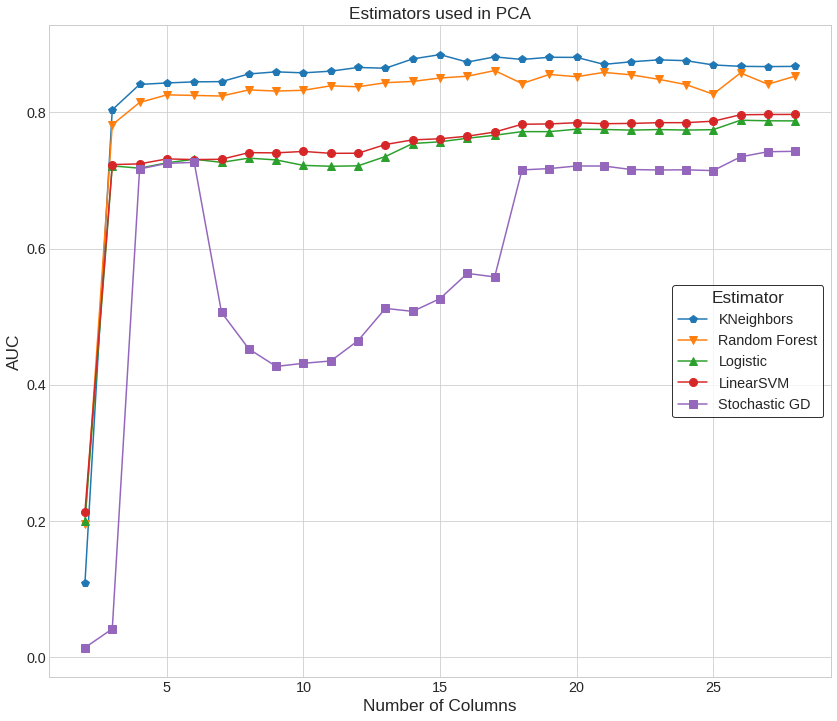

In [0]:
plt.figure(figsize=(14,12))
plt.title('Estimators used in PCA',size='xx-large')
plt.xlabel('Number of Columns',size='xx-large')
plt.xticks(size='x-large')
plt.ylabel('AUC',size='xx-large')
plt.yticks(size='x-large')
x = range(2,29)
plt.plot(x,scores_df_pca.loc['KNeighbors'].values,label='KNeighbors',marker='p',ms=8)
plt.plot(x,scores_df_pca.loc['Random Forest'].values,label='Random Forest',marker='v',ms=8)
plt.plot(x,scores_df_pca.loc['Logistic'].values,label='Logistic',marker='^',ms=8)
plt.plot(x,scores_df_pca.loc['LinearSVM'].values,label='LinearSVM',marker='o',ms=8)
plt.plot(x,scores_df_pca.loc['Stochastic GD'].values,label='Stochastic GD',marker='s',ms=8)
plt.legend(loc='center right',frameon=True,title='Estimator',title_fontsize='xx-large',fontsize='x-large',edgecolor='black')
plt.show()

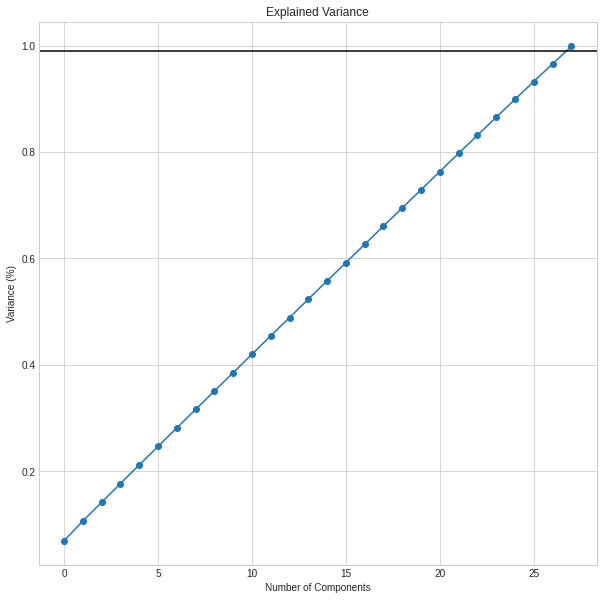

In [0]:
# The main aim of PCA while reducing dataset itself is to restore as much variance of data is possible.
# Each eigenvector is associated with its eigenvalue which shows how much data is spread along that component (eigenvector).
# Hence will try to choose those vectors which are restoring 0.01(99%) of the variance of the original dataset
pca = pipe.named_steps['pca']
plt.figure(figsize=(10,10))
plt.title('Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.plot(np.cumsum(pca.explained_variance_ratio_),marker='o')
plt.axhline(y=0.99,c='black')
plt.show()

### Since PCA had been already applied to the dataset, this results make sense 

In [0]:
#check: https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis
#The important features are the ones that influence more the components and thus,
#have a large absolute value/score on the component(eigenvector).

n_pcs = pca.components_.shape[0]

# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = X_train.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
# each feature impacts each PC(eigenvector) diferently
df_pca = pd.DataFrame(dic.items())
df_pca


,0,1
0,PC0,Amount
1,PC1,V20
2,PC2,V2
3,PC3,V23
4,PC4,V8
5,PC5,V17
6,PC6,V16
7,PC7,V24
8,PC8,V24
9,PC9,V10


In [0]:
df_pca[1].value_counts()

V24       3
V12       2
V25       2
V11       2
V16       2
V2        2
V27       1
V6        1
V17       1
V18       1
V26       1
V28       1
Amount    1
V13       1
V7        1
V23       1
V8        1
V21       1
V10       1
V1        1
V20       1
Name: 1, dtype: int64

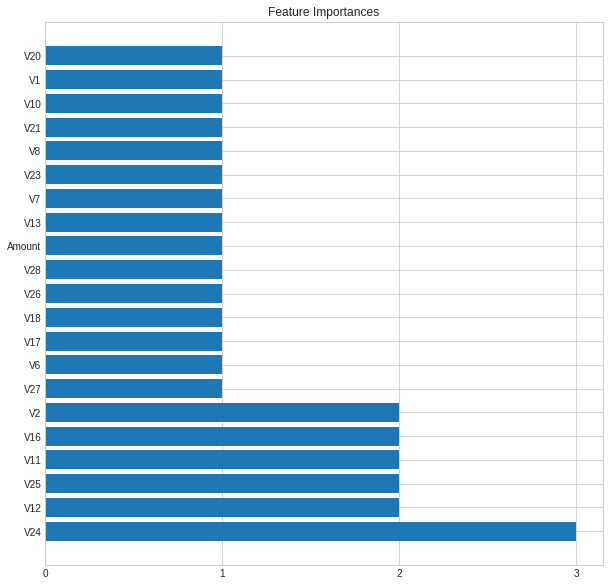

In [0]:
top_features = df_pca[1].value_counts().keys()
top_values = df_pca[1].value_counts().values
plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(top_features, top_values)
plt.xticks(list(range(4)))
plt.yticks(top_features)
plt.show()

# Truncated SVD

In [32]:
scoring_parameters = [auc_score] *4 + [auc_score_2]

X = df.drop(['Time','Class'],axis=1)
y = df['Class']
scores = []

print('Truncated SVD')
t0 = time.time()
for i in range (2,X.shape[1]):
    print('----'*8+f'{i} components'+'----'*8)
    X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.33,random_state=42)

    for name,model,scorer in zip(classifiers_names,classifiers_values,scoring_parameters):
        print('----'*4+f'{name}'+'----'*4)
        scaler = StandardScaler()
        svd = TruncatedSVD(n_components=i,random_state=42)

        svd_pipe = Pipeline([('scaler',scaler),
                             ('svd',svd)])

        X_train_transformed=svd_pipe.fit_transform(X_train,y_train)
        X_test_transformed=svd_pipe.transform(X_test)

        model.fit(X_train_transformed,y_train)
        score = scorer(model,X_test_transformed,y_test)
        scores.append(score)
        print('auc =',score)


print('total time taken:',time.time()-t0)

Truncated SVD
--------------------------------2 components--------------------------------
----------------KNeighbors----------------
auc = 0.026029307072487493
----------------Random Forest----------------
auc = 0.03274725301429002
----------------Logistic----------------
auc = 0.01640041337926275
----------------Stochastic GD----------------
auc = 0.0038535683326669664
----------------LinearSVM----------------
auc = 0.01285336331682016
--------------------------------3 components--------------------------------
----------------KNeighbors----------------
auc = 0.28093331750761735
----------------Random Forest----------------
auc = 0.33825788798320977
----------------Logistic----------------
auc = 0.08316514827208692
----------------Stochastic GD----------------
auc = 0.00909943238546633
----------------LinearSVM----------------
auc = 0.0990974644789685
--------------------------------4 components--------------------------------
----------------KNeighbors----------------
auc = 0.552857

In [0]:
scores = np.array(scores).reshape(27,5).T
columns = [str(i)+ ' columns' for i in list(range(2,X.shape[1]))]
scores_df_svd = pd.DataFrame(scores,index=classifiers_names,columns=columns)

In [35]:
#Max of each classifier and which column
print(scores_df_svd.max(axis=1),'\n')
print(scores_df_svd.idxmax(axis=1))

KNeighbors       0.867331
Random Forest    0.863090
Logistic         0.787323
Stochastic GD    0.742657
LinearSVM        0.796842
dtype: float64 

KNeighbors       28 columns
Random Forest    24 columns
Logistic         28 columns
Stochastic GD    28 columns
LinearSVM        28 columns
dtype: object


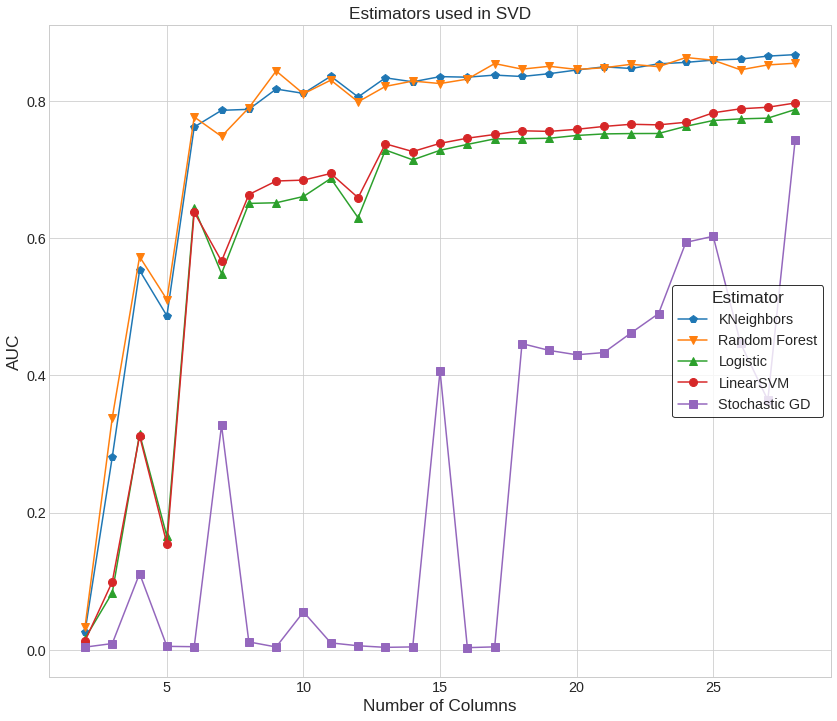

In [40]:
plt.figure(figsize=(14,12))
plt.title('Estimators used in SVD',size='xx-large')
plt.xlabel('Number of Columns',size='xx-large')
plt.xticks(size='x-large')
plt.ylabel('AUC',size='xx-large')
plt.yticks(size='x-large')
x = range(2,29)
plt.plot(x,scores_df_svd.loc['KNeighbors'].values,label='KNeighbors',marker='p',ms=8)
plt.plot(x,scores_df_svd.loc['Random Forest'].values,label='Random Forest',marker='v',ms=8)
plt.plot(x,scores_df_svd.loc['Logistic'].values,label='Logistic',marker='^',ms=8)
plt.plot(x,scores_df_svd.loc['LinearSVM'].values,label='LinearSVM',marker='o',ms=8)
plt.plot(x,scores_df_svd.loc['Stochastic GD'].values,label='Stochastic GD',marker='s',ms=8)
plt.legend(loc='center right',frameon=True,title='Estimator',title_fontsize='xx-large',fontsize='x-large',edgecolor='black')
plt.show()

# NCA

### I've tested NCA in google colab cause it takes a lot of RAM to run even using batches

----------------2 components----------------
components_shape (2, 29)
auc = 0.8614769087051196
----------------3 components----------------
components_shape (3, 29)
auc = 0.8095175626255268
----------------4 components----------------
components_shape (4, 29)
auc = 0.8057148881354608
----------------5 components----------------
components_shape (5, 29)
auc = 0.8628205908749222
----------------6 components----------------
components_shape (6, 29)
auc = 0.8550235240578905
----------------7 components----------------
components_shape (7, 29)
auc = 0.8689474640232944
----------------8 components----------------
components_shape (8, 29)
auc = 0.8478296654502189
----------------9 components----------------
components_shape (9, 29)
auc = 0.8719183447749271
----------------10 components----------------
components_shape (10, 29)
auc = 0.8811166874006868
----------------11 components----------------
components_shape (11, 29)
auc = 0.8770788416306371
----------------12 components----------------


### If you don't want to wait, don't execute the cel bellow, just the next one that has a NCA with 2 components

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/creditcard.csv')
X = df.drop(['Time'],axis=1)
y = df['Class']

chunksize = 18000
t0 = time.time()

nca = NeighborhoodComponentsAnalysis(random_state=42,n_components=2)

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.33,random_state=42)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
list_df = [X_train.loc[i:i+chunksize-1,:] for i in range(0,X_train.shape[0],chunksize)]

for df in list_df:
        df_train=df.pop('Class')
        scaler = StandardScaler()
        nca_pipe = Pipeline([('scaler',scaler),
                        ('nca',nca)])

        nca_pipe.fit(df,df_train)
        nca_pipe.named_steps['nca'].set_params(warm_start=True)
        
X_test = X_test.drop(['Class'],axis=1)
X_train = X_train.drop(['Class'],axis=1)
X_train_transformed=nca_pipe.transform(X_train)
X_test_transformed=nca_pipe.transform(X_test)

model = KNeighborsClassifier(n_jobs=3)
model.fit(X_train_transformed,y_train)
score = auc_score(model,X_test_transformed,y_test)
print('auc =',score)


print('total time taken:',time.time()-t0)

In [13]:
nca_pipe = load('../models/nca_pipe.pkl')
model = load('../models/model_neighboors_2.pkl')

In [10]:
nca_pipe

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('nca',
                 NeighborhoodComponentsAnalysis(callback=None, init='auto',
                                                max_iter=50, n_components=2,
                                                random_state=42, tol=1e-05,
                                                verbose=0, warm_start=True))],
         verbose=False)

In [14]:
model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=3, n_neighbors=5, p=2,
                     weights='uniform')

In [12]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/creditcard.csv')
X = df.drop(['Time','Class'],axis=1)
y = df['Class']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.33,random_state=42)

In [0]:
X_transformed = nca_pipe.transform(X)
X_transformed = pd.DataFrame(X_transformed,index=X.index)

In [30]:
auc_score(model,X_transformed,y)

0.8783767867873105

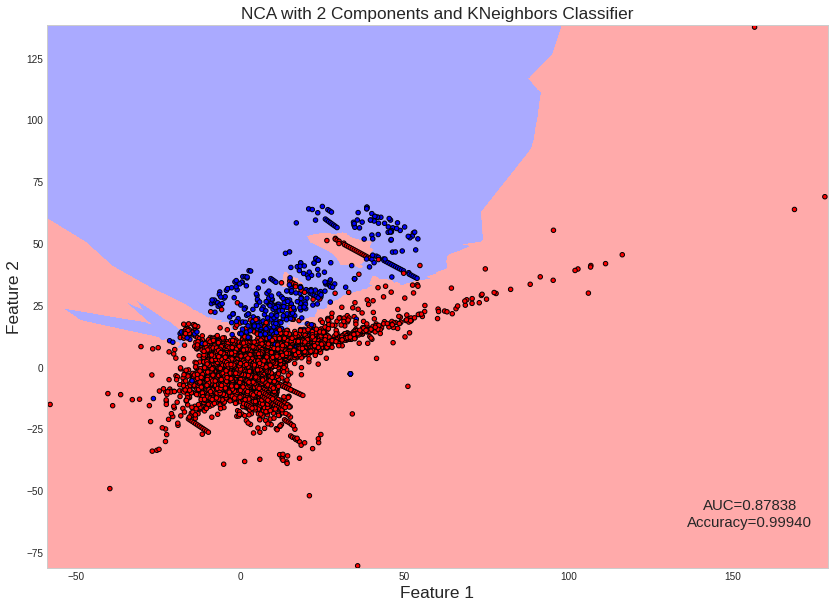

In [31]:
h = .05  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])


x_min, x_max = X_transformed.values[:, 0].min() - 1, X_transformed.values[:, 0].max() + 1
y_min, y_max = X_transformed.values[:, 1].min() - 1, X_transformed.values[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

#score = nca_pipe.named_steps['model'].score(X_test_transformed, y_test)
score = auc_score(model,X_transformed,y)
acu = model.score(X_transformed,y)
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
#Z = nca_pipe.named_steps['model'].predict(np.c_[xx.ravel(), yy.ravel()])
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(14,10))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=.8)

# Plot also the training and testing points
plt.scatter(X_transformed.values[:, 0], X_transformed.values[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('NCA with 2 Components and KNeighbors Classifier',size='xx-large')
plt.xlabel('Feature 1',size='xx-large')
plt.ylabel('Feature 2',size='xx-large')
plt.text(0.9, 0.1, f'AUC={score:.5f}\nAccuracy={acu:.5f}', size=15,
          ha='center', va='center', transform=plt.gca().transAxes)
plt.savefig('../images/NCA_2.png')
plt.show()